In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.cm as cm
#%matplotlib inline
import scipy.misc
from PIL import Image
import scipy.io
import os
import cv2

# Make sure that caffe is on the python path:
#caffe_root = '../../'  # this file is expected to be in {caffe_root}/examples/hed/
#import sys
#sys.path.insert(0, caffe_root + 'python')

import caffe

In [93]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [14]:
#data_root = '../../data/HED-BSDS/'
#with open(data_root+'test.lst') as f:
#    test_lst = f.readlines()
    
#test_lst = [data_root+x.strip() for x in test_lst]
import glob
data_path = "/home/soonyau/dataset/zalando_munit/testB/"

test_lst = [f for f in glob.glob(data_path+'*')]
test_lst.sort()
print(test_lst[0])


/home/soonyau/dataset/zalando_munit/testB/005000_1.jpg


In [16]:
border=0
im_lst = []
for i in range(0, len(test_lst)):
    im = Image.open(test_lst[i])
    in_ = np.array(im, dtype=np.float32)
    in_ = np.pad(in_,((border, border),(border,border),(0,0)),'reflect')
    in_ = in_[:,:,::-1]
    in_ -= np.array((104.00698793,116.66876762,122.67891434))
    im_lst.append(in_)

In [11]:
#Visualization
def plot_single_scale(scale_lst, size):
    pylab.rcParams['figure.figsize'] = size, size/2
    
    plt.figure()
    for i in range(0, len(scale_lst)):
        s=plt.subplot(1,5,i+1)
        plt.imshow(1-scale_lst[i], cmap = cm.Greys_r)
        s.set_xticklabels([])
        s.set_yticklabels([])
        s.yaxis.set_ticks_position('none')
        s.xaxis.set_ticks_position('none')
    plt.tight_layout()

/home/soonyau/dataset/zalando_munit/testB/005001_1.jpg


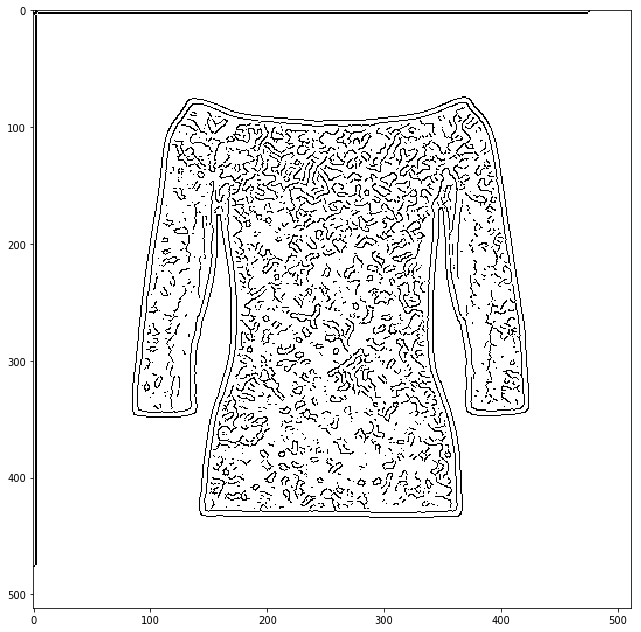

True

In [135]:
def postprocess_img(img):
    rows,cols = img.shape
    #img = 255*(1-img)
    tx = -35
    ty = -35
    M = np.float32([[1,0,tx],[0,1,ty]])
    ret_img = cv2.warpAffine(img,M,(cols,rows))
    
    kernel_size = 7
    ret_img = cv2.GaussianBlur(ret_img, (kernel_size, kernel_size), 0)
    
    ret_img = 255*(1-ret_img)
    ret_img = np.uint8(ret_img)
    
    #thres = 25
    #black_mask = ret_img <= thres
    #white_mask = ret_img > thres
    #ret_img[black_mask] = 0
    #ret_img[white_mask] = 255
    
    #ret_img = 255-cv2.Canny(ret_img, 50,50)
    return (ret_img)

idx = 1

in_ = im_lst[idx]
print(test_lst[idx])
in_ = in_.transpose((2,0,1))
#remove the following two lines if testing with cpu
caffe.set_mode_gpu()
caffe.set_device(0)
# load net
model_root = './'
net = caffe.Net(model_root+'deploy.prototxt', model_root+'hed_pretrained_bsds.caffemodel', caffe.TEST)
# shape for input (data blob is N x C x H x W), set data
net.blobs['data'].reshape(1, *in_.shape)
net.blobs['data'].data[...] = in_
# run net and take argmax for prediction
net.forward()
out1 = net.blobs['sigmoid-dsn1'].data[0][0,:,:]
out2 = net.blobs['sigmoid-dsn2'].data[0][0,:,:]
out3 = net.blobs['sigmoid-dsn3'].data[0][0,:,:]
out4 = net.blobs['sigmoid-dsn4'].data[0][0,:,:]
out5 = net.blobs['sigmoid-dsn5'].data[0][0,:,:]
fuse = net.blobs['sigmoid-fuse'].data[0][0,:,:]

fuse = postprocess_img(out1)
plt.imshow(fuse, cmap = cm.Greys_r)
plt.show()
#scale_lst = [fuse]
#plot_single_scale(scale_lst, 22)
cv2.imwrite("fuse.jpg", out1)

#scale_lst = [out1, out2, out3, out4, out5]
#plot_single_scale(scale_lst, 22)